In [1]:
import xarray as xr
import numpy as np
import os.path as op
import xgcm.grid as xgd
import sys
import gsw
import scipy.interpolate as naiso
import scipy.integrate as intg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append('../')
import xroms as xm

In [3]:
datadir = '../test_data/'

In [4]:
eta_s, eta_e = (510, 670)
xi_s, xi_e = (670, 840)

In [5]:
ds_grid = xr.open_dataset(op.join(datadir, 'AS24th_gridfile.nc'))
ds_grid = ds_grid.isel(eta_psi=slice(eta_s,eta_e-1), eta_rho=slice(eta_s,eta_e),
                       eta_u=slice(eta_s,eta_e), eta_v=slice(eta_s,eta_e-1),
                       xi_psi=slice(xi_s,xi_e-1), xi_rho=slice(xi_s,xi_e), 
                       xi_u=slice(xi_s,xi_e-1), xi_v=slice(xi_s,xi_e))
# ds_grid = ds_grid.isel(eta_psi=slice(eta_s,eta_e), eta_rho=slice(eta_s,eta_e),
#                        eta_u=slice(eta_s,eta_e), eta_v=slice(eta_s,eta_e),
#                        xi_psi=slice(xi_s,xi_e), xi_rho=slice(xi_s,xi_e), 
#                        xi_u=slice(xi_s,xi_e), xi_v=slice(xi_s,xi_e))
ds_grid

<xarray.Dataset>
Dimensions:    (bath: 0, eta_psi: 159, eta_rho: 160, eta_u: 160, eta_v: 159, one: 1, s_rho: 32, s_w: 33, xi_psi: 169, xi_rho: 170, xi_u: 169, xi_v: 170)
Dimensions without coordinates: bath, eta_psi, eta_rho, eta_u, eta_v, one, s_rho, s_w, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    xl         (one) float64 9.969e+36
    el         (one) float64 9.969e+36
    depthmin   (one) float64 9.969e+36
    depthmax   (one) float64 9.969e+36
    spherical  (one) |S1 b'T'
    angle      (eta_rho, xi_rho) float64 9.865e-05 9.865e-05 9.865e-05 ...
    h          (eta_rho, xi_rho) float64 4.028e+03 4.025e+03 4.026e+03 ...
    hraw       (bath, eta_rho, xi_rho) float64 
    alpha      (eta_rho, xi_rho) float64 9.969e+36 9.969e+36 9.969e+36 ...
    f          (eta_rho, xi_rho) float64 3.946e-05 3.946e-05 3.946e-05 ...
    pm         (eta_rho, xi_rho) float64 0.0002244 0.0002244 0.0002244 ...
    pn         (eta_rho, xi_rho) float64 0.0002244 0.0002244 0.0002244 ...
    dndx       (

In [6]:
zr = ds_grid.z_rho0[::-1]
zw = ds_grid.z_w0[::-1]
x_r = ds_grid.x_rho
y_r = ds_grid.y_rho
x_v = ds_grid.x_v
y_u = ds_grid.y_u
lon_psi = ds_grid.lon_psi
lat_psi = ds_grid.lat_psi

In [7]:
ds = xr.open_dataset(op.join(datadir, 'roms_avg_M01.nc'))

In [8]:
# convert everything that doesn't have a time dimension to coord
def roms_set_coords(ds):
    new_coords = [varname for varname in ds.data_vars
                  if ('time' not in ds[varname].dims)]
    ds_new = ds.set_coords(new_coords)
    return ds_new

roms_set_coords(ds)

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 898, eta_v: 897, s_rho: 32, s_w: 33, time: 10, xi_rho: 1082, xi_u: 1081)
Coordinates:
    spherical   |S1 b'T'
    xl          float32 9.969e+36
    el          float32 9.969e+36
  * xi_rho      (xi_rho) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * xi_u        (xi_u) float32 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
  * eta_rho     (eta_rho) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * eta_v       (eta_v) float32 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
    Vtransform  float32 2.0
  * s_rho       (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
  * s_w         (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    sc_r        (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
    sc_w        (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    Cs_r        (s_rho) float32 -0.896205 -0.719762 -0.577987 -0.464067 ...
    Cs_w        (s_w) float32 -1.0 

In [9]:
ds = ds.isel(eta_rho=slice(eta_s,eta_e),eta_v=slice(eta_s,eta_e-1),
             xi_rho=slice(xi_s,xi_e), xi_u=slice(xi_s,xi_e-1))
# ds = ds.isel(eta_rho=slice(eta_s,eta_e),eta_v=slice(eta_s,eta_e),
#              xi_rho=slice(xi_s,xi_e), xi_u=slice(xi_s,xi_e))
ds

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 160, eta_v: 159, s_rho: 32, s_w: 33, time: 10, xi_rho: 170, xi_u: 169)
Coordinates:
  * xi_rho      (xi_rho) float32 671.0 672.0 673.0 674.0 675.0 676.0 677.0 ...
  * xi_u        (xi_u) float32 671.5 672.5 673.5 674.5 675.5 676.5 677.5 ...
  * eta_rho     (eta_rho) float32 511.0 512.0 513.0 514.0 515.0 516.0 517.0 ...
  * eta_v       (eta_v) float32 511.5 512.5 513.5 514.5 515.5 516.5 517.5 ...
  * s_rho       (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
  * s_w         (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    lon_rho     (eta_rho, xi_rho) float32 60.9667 61.0083 61.05 61.0917 ...
    lat_rho     (eta_rho, xi_rho) float32 15.7413 15.7413 15.7413 15.7413 ...
    lon_u       (eta_rho, xi_u) float32 60.9875 61.0292 61.0708 61.1125 ...
    lat_u       (eta_rho, xi_u) float32 15.7413 15.7413 15.7413 15.7413 ...
    lon_v       (eta_v, xi_rho) float32 60.9667 61.0083 61.05 61.0917 ...
    lat_v   

In [10]:
grid = xgd.Grid(ds, periodic=[])
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   xi_rho (170) --> inner
  * inner    xi_u (169) --> center
Z Axis (not periodic):
  * center   s_rho (32) --> outer
  * outer    s_w (33) --> center
T Axis (not periodic):
  * center   time (10)
Y Axis (not periodic):
  * center   eta_rho (160) --> inner
  * inner    eta_v (159) --> center

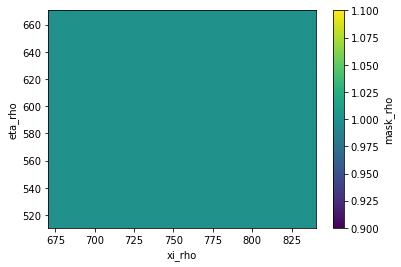

In [11]:
mask_rho = ds.mask_rho.load()
mask_rho.plot()

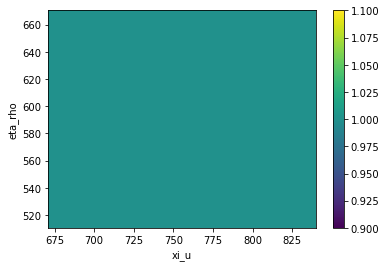

In [12]:
mask_u = ~(grid.interp(mask_rho, 'X')<1)
mask_v = ~(grid.interp(mask_rho, 'Y')<1)
mask_u.plot()

In [13]:
u_2d = ds.u[0,::-1][0]
v_2d = ds.v[0,::-1][0]

In [14]:
eke = .5*(grid.interp(v_2d.where(mask_v)**2, 'Y', to='center', boundary='fill') 
          + grid.interp(u_2d.where(mask_u)**2, 'X', to='center', boundary='fill'))
eke

<xarray.DataArray (eta_rho: 160, xi_rho: 170)>
array([[ 0.04412 ,  0.044255,  0.042233, ...,  0.007298,  0.007408,  0.003748],
       [ 0.090381,  0.089045,  0.085064, ...,  0.013725,  0.013155,  0.006472],
       [ 0.097039,  0.09405 ,  0.089076, ...,  0.02112 ,  0.020502,  0.010154],
       ..., 
       [ 0.070883,  0.150954,  0.169676, ...,  0.0269  ,  0.025772,  0.011358],
       [ 0.103598,  0.217706,  0.239336, ...,  0.025629,  0.022085,  0.009704],
       [ 0.136893,  0.284104,  0.304601, ...,  0.016753,  0.013661,  0.005891]], dtype=float32)
Coordinates:
  * eta_rho  (eta_rho) float32 511.0 512.0 513.0 514.0 515.0 516.0 517.0 ...
  * xi_rho   (xi_rho) float32 671.0 672.0 673.0 674.0 675.0 676.0 677.0 ...

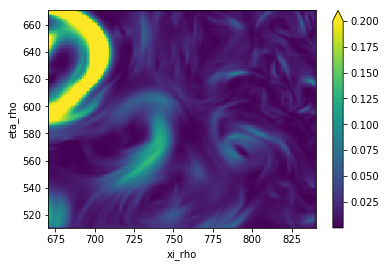

In [17]:
eke.plot(vmax=.2)

In [18]:
temp_2d = ds.temp[0,::-1][0]
x_rho = ds_grid.x_rho.load()
y_rho = ds_grid.y_rho.load()

In [19]:
grad_t_sq = (grid.interp((grid.diff(temp_2d.where(mask_rho), 'X')
                          / grid.diff(x_rho.where(mask_rho), 'X'))**2, 'X', boundary='fill')
             + grid.interp((grid.diff(temp_2d.where(mask_rho), 'Y')
                            / grid.diff(y_rho.where(mask_rho), 'Y'))**2, 'Y', boundary='fill')
            )
grad_t_sq

<xarray.DataArray (eta_rho: 160, xi_rho: 170)>
array([[  2.219121e-11,   1.814520e-11,   9.266009e-12, ...,   4.218063e-11,
          2.356033e-11,   1.752758e-11],
       [  5.477844e-11,   4.278330e-11,   1.327289e-11, ...,   6.890827e-11,
          6.849148e-11,   7.061039e-11],
       [  9.359542e-11,   8.243507e-11,   2.112714e-11, ...,   9.095413e-11,
          1.105992e-10,   1.213380e-10],
       ..., 
       [  8.356602e-10,   9.201531e-10,   1.018678e-09, ...,   1.939736e-10,
          5.265364e-11,   2.191205e-11],
       [  2.683488e-09,   2.843914e-09,   2.994492e-09, ...,   1.221392e-10,
          3.844936e-11,   1.988369e-11],
       [  1.860102e-09,   1.955426e-09,   2.033594e-09, ...,   1.138209e-10,
          6.142574e-11,   1.984238e-11]])
Coordinates:
  * eta_rho  (eta_rho) float32 511.0 512.0 513.0 514.0 515.0 516.0 517.0 ...
  * xi_rho   (xi_rho) float32 671.0 672.0 673.0 674.0 675.0 676.0 677.0 ...

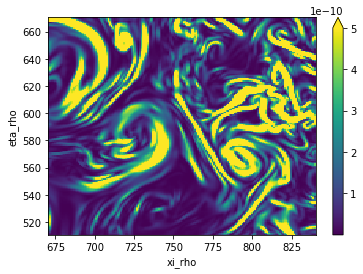

In [21]:
grad_t_sq.plot(vmax=5e-10)

In [22]:
y_u = xr.DataArray(ds_grid.y_u.values, dims=u_2d.dims, coords=u_2d.coords).where(mask_u)
x_v = xr.DataArray(ds_grid.x_v.values, dims=v_2d.dims, coords=v_2d.coords).where(mask_v)

In [24]:
dvdx = grid.diff(v_2d, 'X') / grid.diff(x_v, 'X')
dudy = grid.diff(u_2d, 'Y') / grid.diff(y_u, 'Y')
vort = dvdx - dudy

vort

<xarray.DataArray (eta_v: 159, xi_u: 169)>
array([[  1.099554e-06,   1.397935e-08,   1.691680e-06, ...,   1.546699e-05,
          1.519768e-05,   1.520076e-05],
       [  6.197984e-07,  -3.395479e-07,   1.012254e-06, ...,   1.588119e-05,
          1.569693e-05,   1.554573e-05],
       [  1.398666e-07,  -6.798679e-07,   3.488357e-07, ...,   1.488660e-05,
          1.466313e-05,   1.408261e-05],
       ..., 
       [ -2.085428e-05,  -2.075897e-05,  -2.084757e-05, ...,   2.649862e-05,
          4.541658e-06,  -1.349096e-05],
       [ -2.581843e-05,  -2.611935e-05,  -2.652383e-05, ...,   1.263558e-05,
         -2.027160e-06,  -1.309944e-05],
       [ -2.254070e-05,  -2.215640e-05,  -2.152564e-05, ...,   5.760173e-06,
         -5.600416e-06,  -1.414993e-05]])
Coordinates:
  * eta_v    (eta_v) float32 511.5 512.5 513.5 514.5 515.5 516.5 517.5 518.5 ...
  * xi_u     (xi_u) float32 671.5 672.5 673.5 674.5 675.5 676.5 677.5 678.5 ...

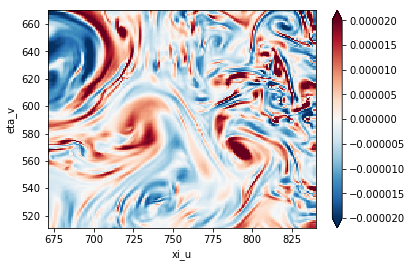

In [25]:
vort.plot(vmax=2e-5)